# Первичный анализ данных из БД

In [2]:
import psycopg2
import pandas as pd

In [3]:
HOST = 'ep-green-butterfly-a26qo6f3.eu-central-1.aws.neon.tech'
PORT = 5432
DATABASE = 'datadb'
USER = 'datadb_owner'
PASSWORD = 'BmV3l0GArdNT'

In [4]:
connection = psycopg2.connect(
    host = HOST,
    port = PORT,
    database = DATABASE,
    user = USER,
    password = PASSWORD,
)

In [5]:
connection

<connection object at 0x000001E6B2143AB0; dsn: 'user=datadb_owner password=xxx dbname=datadb host=ep-green-butterfly-a26qo6f3.eu-central-1.aws.neon.tech port=5432', closed: 0>

In [6]:
cursor = connection.cursor()
query = """select * from cd.inflation"""
cursor.execute(query)
data = cursor.fetchall()
cursor.close()
InfDf = pd.DataFrame(data, columns = ['infid', 'inflation', 'data'])

In [7]:
InfDf

,infid,inflation,data
0,0,28.93,2000-01-01
1,1,25.11,2000-02-01
2,2,22.49,2000-03-01
3,3,19.95,2000-04-01
4,4,19.40,2000-05-01
...,...,...,...
140,140,3.05,2019-01-01
141,141,4.91,2020-01-01
142,142,8.39,2021-01-01
143,143,11.92,2022-01-01


## Цель:
1. Вывести инфляцию в виде графика
2. Вывести рост зарплат по профессиям (сделать категорию)
3. Вывести в один график зарплату и инфляцию

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Получение данных из БД

In [12]:
cursor = connection.cursor()
query = """select to_char(i.infdata, 'YYYY') as year, round(avg(i.inflation), 2) as inflation 
from cd.inflation i 
group by to_char(i.infdata, 'YYYY')
order by to_char(i.infdata, 'YYYY');"""
cursor.execute(query)
data = cursor.fetchall()
cursor.close()
InfDf = pd.DataFrame(data, columns = ['year', 'inflation'])

## Вывод инфляции на изображение

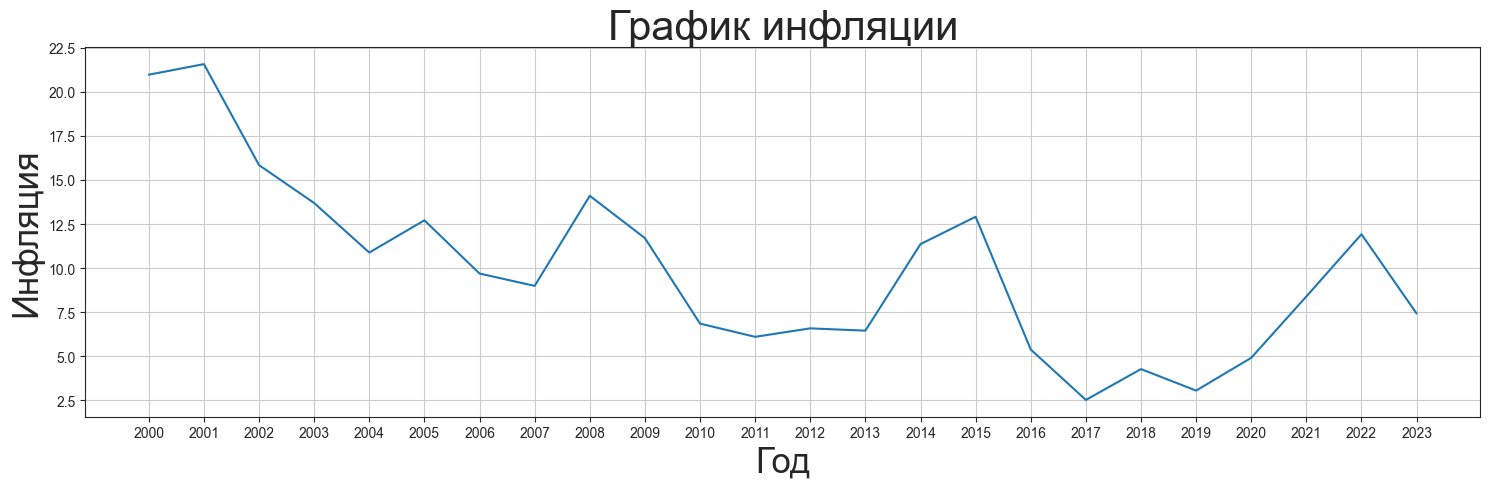

In [50]:
plt.figure(figsize=(15,5))
axes = sns.lineplot(data=InfDf, x="year", y="inflation")
plt.title('График инфляции', fontsize=30)
axes.set_xlabel('Год', fontsize=25)
axes.set_ylabel('Инфляция', fontsize=25)
plt.grid(True)
plt.tight_layout()
plt.show()